# Week 5-8 Part2 Assignment - ML system using pySpark v1.2

#### Submitted by : Jophy Joseph                             Date: August 10, 2022

####  Objective:- Build a ML model to predict the employee compensation. The application is modelled using Spark.


## Predicting Employee Compensation

## Data Dictionary
<br>**Year Type** - Fiscal (July through June) or Calendar (January through December)
<br>**Year** - An accounting period of 12 months. The City and County of San Francisco operates on a fiscal year that begins on July 1 and ends on June 30 the following year. The Fiscal Year ending June 30, 2012 is represented as FY2011-2012.
<br>**Organization Group Code** - Org Group is a group of Departments. For example, the Public Protection Org Group includes departments such as the Police,Fire, Adult Probation, District Attorney, and Sheriff.
<br> **Organization Group** - Org Group is a group of Departments. For example, the Public Protection Org Group includes departments such as the Police,
Fire, Adult Probation, District Attorney, and Sheriff.
<br>**Department Code** - Departments are the primary organizational unit used by the Cityand County of San Francisco. Examples include Recreation and
Parks, Public Works, and the Police Department.
<br>**Department Code** - Departments are the primary organizational unit used by the City and County of San Francisco. Examples include Recreation and Parks, Public Works, and the Police Department.
<br>**Union Code** - Unions represent employees in collective bargaining agreements. A job belongs to one union, although some jobs are unrepresented (usually temporarily).
<br>**Union** - Unions represent employees in collective bargaining agreements. A job belongs to one union, although some jobs are unrepresented (usually temporarily).
<br>**Job Family Code** Job Family combines similar Jobs into meaningful groups.
<br>**Job Family** Job Family combines similar Jobs into meaningful groups.
<br>**Employee Identifier** Each distinct number in the “Employee Identifier” column represents one employee. These identifying numbers are not meaningful but rather are randomly assigned for the purpose of building this dataset. The column does not appear on the
Employee Compensation report hosted on openbook.sfgov.org,
but that report does show one row for each employee. Employee
ID has been included here to allow users to reconstruct the
original report. Note that each employee’s identifier will change
each time this dataset is updated, so comparisons by employee
across multiple versions of the dataset are not possible.
<br>**Salaries** - Normal salaries paid to permanent or temporary City employees.
<br>**Overtime** - Amounts paid to City employees working in excess of 40 hours
per week.
<br>**Other Salaries** - Various irregular payments made to City employees including premium pay, incentive pay, or other one-time payments. Total Salary Number The sum of all salaries paid to City employees.
<br>**Retirement** City contributions to employee retirement plans.
<br>**Health/Dental** City-paid premiums to health and dental insurance plans covering City employees. To protect confidentiality as legally required, pro-rated citywide averages are presented in lieu of employee-specific health and dental benefits.
<br>**Other Benefits** Mandatory benefits paid on behalf of employees, such as Social Security (FICA and Medicare) contributions, unemployment
insurance premiums, and minor discretionary benefits not included in the above categories.
<br>**Total Benefits** The sum of all benefits paid to City employees.
<br>**Total Compensation** The sum of all salaries and benefits paid to City employees.

In [2]:
!pip install pyspark==3.3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 47 kB/s 
     |████████████████████████████████| 199 kB 47.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=085c0a2e16c1befd9a9da1ae3cef9d64c5d87583a36011152ce1d8bee0456465
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [3]:
!pip install -q findspark

In [4]:
import findspark
findspark.init()

In [5]:
findspark.find()

'/usr/local/lib/python3.7/dist-packages/pyspark'

In [6]:
from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F


spark = SparkSession \
       .builder \
       .appName("Part-2: ML system using pySpark") \
       .getOrCreate()

spark

Read the data and answer the following questions to predict employee compensation

## 1. Read the Data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
emp_df = spark.read.csv('/content/drive/My Drive/data/Employee_Compensation.csv', header=True, inferSchema=True)

In [9]:
type(emp_df)

pyspark.sql.dataframe.DataFrame

In [10]:
emp_df.show(5)

+---------+----+-----------------------+--------------------+---------------+--------------------+----------+--------------------+---------------+--------------------+--------+--------------------+-------------------+---------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+
|Year Type|Year|Organization Group Code|  Organization Group|Department Code|          Department|Union Code|               Union|Job Family Code|          Job Family|Job Code|                 Job|Employee Identifier| Salaries|Overtime|Other Salaries|Total Salary|Retirement|Health/Dental|Other Benefits|Total Benefits|Total Compensation|
+---------+----+-----------------------+--------------------+---------------+--------------------+----------+--------------------+---------------+--------------------+--------+--------------------+-------------------+---------+--------+--------------+------------+----------+-------------+--------------+--------------+---

### 1.1 Display the number of rows and columns in the dataset

In [11]:
print("Number of rows: ",emp_df.count())   # no. of rows

Number of rows:  291825


In [12]:
print("Number of columns: ",len(emp_df.columns))  # no. of columns

Number of columns:  22


### 1.2 Check the datatype of the variables

In [13]:
# Datatypes of the variables in emp_df
emp_df.printSchema()

root
 |-- Year Type: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Organization Group Code: integer (nullable = true)
 |-- Organization Group: string (nullable = true)
 |-- Department Code: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- Union Code: integer (nullable = true)
 |-- Union: string (nullable = true)
 |-- Job Family Code: string (nullable = true)
 |-- Job Family: string (nullable = true)
 |-- Job Code: string (nullable = true)
 |-- Job: string (nullable = true)
 |-- Employee Identifier: integer (nullable = true)
 |-- Salaries: double (nullable = true)
 |-- Overtime: double (nullable = true)
 |-- Other Salaries: double (nullable = true)
 |-- Total Salary: double (nullable = true)
 |-- Retirement: double (nullable = true)
 |-- Health/Dental: double (nullable = true)
 |-- Other Benefits: double (nullable = true)
 |-- Total Benefits: double (nullable = true)
 |-- Total Compensation: double (nullable = true)



### 2. Convert the incorrect column type into its suitable column type. And drop the redundant features

Redundant columns : 'Total Salary'  and 'Total Benefits' -- dropping these

In [27]:
# From the dataset, We observe that 
# 'Total Salary' = 'Salaries' +  'Overtime' + 'Other Salaries'
# Verifying with the first row

print("Salaries + Overtime + Other Salaries =  ",emp_df.first()['Salaries'] + emp_df.first()['Overtime'] + emp_df.first()['Other Salaries'] )
print("Total Salary                         =  ",emp_df.first()['Total Salary'])

print('\n')

# 'Total Benefits' =  'Retirement' + 'Health/Dental' + 'Other Benefits'
# Verifying with the first row

print("'Retirement' + 'Health/Dental' + 'Other Benefits' =  ",emp_df.first()['Retirement'] + emp_df.first()['Health/Dental'] + emp_df.first()['Other Benefits'] )
print("Total Benefits                                    =  ",emp_df.first()['Total Benefits'])

Salaries + Overtime + Other Salaries =   115973.16
Total Salary                         =   115973.16


'Retirement' + 'Health/Dental' + 'Other Benefits' =   43463.49
Total Benefits                                    =   43463.49


In [104]:
emp_df = emp_df_org

In [105]:
# Hence we can drop columns 'Total Salary' and 'Total Benefits' as they are redundant

#making a copy of the dataframe
emp_df_org = emp_df

#dropping the redundant columns
emp_df = emp_df.drop('Total Salary', 'Total Benefits')

emp_df.show(2)
len(emp_df.columns)

+---------+----+-----------------------+--------------------+---------------+-----------------+----------+--------------------+---------------+--------------------+--------+--------------------+-------------------+---------+--------+--------------+----------+-------------+--------------+------------------+
|Year Type|Year|Organization Group Code|  Organization Group|Department Code|       Department|Union Code|               Union|Job Family Code|          Job Family|Job Code|                 Job|Employee Identifier| Salaries|Overtime|Other Salaries|Retirement|Health/Dental|Other Benefits|Total Compensation|
+---------+----+-----------------------+--------------------+---------------+-----------------+----------+--------------------+---------------+--------------------+--------+--------------------+-------------------+---------+--------+--------------+----------+-------------+--------------+------------------+
|   Fiscal|2016|                      1|   Public Protection|            DAT

20

 Converting  the incorrect column type into its suitable column type. The datatypes of 'Salaries','Overtime','Other Salaries','Retirement','Health/Dental','Other Benefits','Total Compensation' changed  from double to float. 

In [106]:
# changing datatype from double to float 
from pyspark.sql.types import FloatType
from pyspark.sql.functions import col
doubleCols = ['Salaries','Overtime','Other Salaries','Retirement','Health/Dental','Other Benefits','Total Compensation' ]

for col_name in doubleCols:
    emp_df = emp_df.withColumn(col_name, col(col_name).cast(FloatType()))

emp_df.printSchema()

root
 |-- Year Type: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Organization Group Code: integer (nullable = true)
 |-- Organization Group: string (nullable = true)
 |-- Department Code: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- Union Code: integer (nullable = true)
 |-- Union: string (nullable = true)
 |-- Job Family Code: string (nullable = true)
 |-- Job Family: string (nullable = true)
 |-- Job Code: string (nullable = true)
 |-- Job: string (nullable = true)
 |-- Employee Identifier: integer (nullable = true)
 |-- Salaries: float (nullable = true)
 |-- Overtime: float (nullable = true)
 |-- Other Salaries: float (nullable = true)
 |-- Retirement: float (nullable = true)
 |-- Health/Dental: float (nullable = true)
 |-- Other Benefits: float (nullable = true)
 |-- Total Compensation: float (nullable = true)



### 3. Check basic statistics and perform necessary data preprocessing (Like removing negative amount)

Checking the numerical(income) columns for any negative amounts

In [107]:
sal_col = ['Salaries', 'Overtime','Other Salaries','Retirement', 'Health/Dental', 'Other Benefits', 'Total Compensation']
tot = 0
for col in sal_col:
  print("No. of rows having negative values in {}: ".format(col),emp_df.filter(emp_df[col]<0).count())
  tot = tot + emp_df.filter(emp_df[col]<0).count()
print(tot) 


No. of rows having negative values in Salaries:  79
No. of rows having negative values in Overtime:  30
No. of rows having negative values in Other Salaries:  62
No. of rows having negative values in Retirement:  422
No. of rows having negative values in Health/Dental:  344
No. of rows having negative values in Other Benefits:  679
No. of rows having negative values in Total Compensation:  246
1862


In [108]:
#checking for columns with zero values
for col in sal_col:
  print("No of rows having negative values in column {} = ".format(col),emp_df.filter(emp_df[col] == 0).count())

No of rows having negative values in column Salaries =  3699
No of rows having negative values in column Overtime =  167869
No of rows having negative values in column Other Salaries =  93224
No of rows having negative values in column Retirement =  45872
No of rows having negative values in column Health/Dental =  14300
No of rows having negative values in column Other Benefits =  932
No of rows having negative values in column Total Compensation =  2


In [109]:
# filtering out only those rows that have values >= 0 in these columns
for col in sal_col:
  print("No of rows having negative values in column {} = ".format(col),emp_df.filter(emp_df[col] < 0).count())
  emp_df = emp_df.filter(emp_df[col] >= 0)

No of rows having negative values in column Salaries =  79
No of rows having negative values in column Overtime =  29
No of rows having negative values in column Other Salaries =  57
No of rows having negative values in column Retirement =  376
No of rows having negative values in column Health/Dental =  297
No of rows having negative values in column Other Benefits =  596
No of rows having negative values in column Total Compensation =  0


So now emp_df has no rows having negative amount values

In [110]:
emp_df.count()

290391

### 4. Perform Missing Value Analysis

In [111]:
from pyspark.sql.functions import isnull, when, count, col

print(emp_df.select([count(when(isnull(c), c)).alias(c) for c in emp_df.columns]).show())

+---------+----+-----------------------+------------------+---------------+----------+----------+-----+---------------+----------+--------+---+-------------------+--------+--------+--------------+----------+-------------+--------------+------------------+
|Year Type|Year|Organization Group Code|Organization Group|Department Code|Department|Union Code|Union|Job Family Code|Job Family|Job Code|Job|Employee Identifier|Salaries|Overtime|Other Salaries|Retirement|Health/Dental|Other Benefits|Total Compensation|
+---------+----+-----------------------+------------------+---------------+----------+----------+-----+---------------+----------+--------+---+-------------------+--------+--------+--------------+----------+-------------+--------------+------------------+
|        0|   0|                      0|                 0|              0|         0|        43|   43|             45|        45|       0|  0|                  0|       0|       0|             0|         0|            0|           

Checking out the data, I observe  only 3 unique job codes (9152, 3278, 1116) that have blank values, corresponding to Job Family code and  Job family.  In all these cases, Union code and  Union are also  blank except 2 rows with Union code 351, both of which corressponds to Job Code 1116.  The values in all other columns are populated. Hence we shoould impute the blanks with the appropriate Job Family code and Union code

In [125]:
# Imputing the missing values
# First filter out the rows that have missing Job Family code.
tmp_df = emp_df.filter(emp_df["Job Family Code"].isNull())
print("rows with blank Job Family code: ",tmp_df.count())

# Next find the distinct job codes 
tmp_df = emp_df.filter(emp_df["Job Family Code"].isNull())

job_code_list = tmp_df.select("Job Code").distinct().show()  # distinct job codes that have no job family codes
print(type(job_code_list))

rows with blank Job Family code:  45
+--------+
|Job Code|
+--------+
|    9152|
|    3278|
|    1116|
+--------+

<class 'NoneType'>


In [126]:
emp_df.count()

290391

In [127]:
tmp_df.count()

45

In [128]:
#temporarily dropping these 45 rows for imputation. Will impute on the smaller dataframe (tmp_df) and  later concatenate both the dataframes
emp_df1 = emp_df.dropna(how='any')
print(emp_df1.count())

290346


In [137]:
#emp_df.filter(emp_df["Job Code"].li)
emp_df.select('Union Code', 'Union','Job Family Code', 'Job Family', 'Job Code').distinct().where(col("Job Code").like('915%')).show(5)

+----------+--------------------+---------------+--------------+--------+
|Union Code|               Union|Job Family Code|    Job Family|Job Code|
+----------+--------------------+---------------+--------------+--------+
|       200|Transportation Wo...|           9100|Street Transit|    9155|
|       200|Transportation Wo...|           9100|Street Transit|    9156|
|      null|                null|           null|          null|    9152|
|        21|Prof & Tech Engin...|           0900|    Management|    9151|
|       200|Transportation Wo...|           9100|Street Transit|    9157|
+----------+--------------------+---------------+--------------+--------+
only showing top 5 rows



In [138]:
emp_df.select('Union Code', 'Union','Job Family Code', 'Job Family','Job Code').distinct().where(col("Job Code").like('327%')).show(5)

+----------+--------------------+---------------+----------+--------+
|Union Code|               Union|Job Family Code|Job Family|Job Code|
+----------+--------------------+---------------+----------+--------+
|      null|                null|           null|      null|    3278|
|       790|SEIU - Miscellane...|           3200|Recreation|    3279|
+----------+--------------------+---------------+----------+--------+



In [139]:
emp_df.select('Union Code', 'Union','Job Family Code', 'Job Family','Job Code').distinct().where(col("Job Code").like('111%')).show(5)

+----------+--------------------+---------------+--------------------+--------+
|Union Code|               Union|Job Family Code|          Job Family|Job Code|
+----------+--------------------+---------------+--------------------+--------+
|       351|Municipal Executi...|           1100|Administrative & ...|    1117|
|       351|Municipal Exec As...|           null|                null|    1116|
|       351|Municipal Executi...|           1100|Administrative & ...|    1119|
|       351|Municipal Executi...|           1100|Administrative & ...|    1115|
|       351|Municipal Executi...|           0900|          Management|    1110|
+----------+--------------------+---------------+--------------------+--------+



In [140]:
tmp_df.select('Union Code', 'Union','Job Family Code', 'Job Family', 'Job Code').show()

+----------+--------------------+---------------+----------+--------+
|Union Code|               Union|Job Family Code|Job Family|Job Code|
+----------+--------------------+---------------+----------+--------+
|       200|Transportation Wo...|           null|      null|    9152|
|       200|Transportation Wo...|           null|      null|    9152|
|       790|SEIU - Miscellane...|           null|      null|    3278|
|       790|SEIU - Miscellane...|           null|      null|    3278|
|       790|SEIU - Miscellane...|           null|      null|    3278|
|       790|SEIU - Miscellane...|           null|      null|    3278|
|       200|Transportation Wo...|           null|      null|    9152|
|       790|SEIU - Miscellane...|           null|      null|    3278|
|       790|SEIU - Miscellane...|           null|      null|    3278|
|       790|SEIU - Miscellane...|           null|      null|    3278|
|       790|SEIU - Miscellane...|           null|      null|    3278|
|       351|Municipa

Based on the above analysis, imputing the most appropriate values for the missing value columns of the 3 distinct Job Codes (45 rows affected)

In [143]:

from pyspark.sql.functions import when

#Imputing 'Union Code' 
tmp_df = tmp_df.withColumn("Union Code", when(emp_df['Job Code'] == "9152","200") \
       .when(emp_df['Job Code'] == "3278","790") \
      #.when(emp_df['Job Code'] == "1116","")
       .otherwise(emp_df['Union Code']))

tmp_df.select('Union Code', 'Union','Job Family Code', 'Job Family','Job Code').where(col("Job Code").isin('9152','3278','1116')).show(5)

+----------+--------------------+---------------+----------+--------+
|Union Code|               Union|Job Family Code|Job Family|Job Code|
+----------+--------------------+---------------+----------+--------+
|       200|Transportation Wo...|           null|      null|    9152|
|       200|Transportation Wo...|           null|      null|    9152|
|       790|SEIU - Miscellane...|           null|      null|    3278|
|       790|SEIU - Miscellane...|           null|      null|    3278|
|       790|SEIU - Miscellane...|           null|      null|    3278|
+----------+--------------------+---------------+----------+--------+
only showing top 5 rows



In [144]:
#Imputing 'Union' 
tmp_df = tmp_df.withColumn("Union", when(emp_df['Job Code'] == "9152","Transportation Workers, Local 200") \
      .when(emp_df['Job Code'] == "3278","SEIU - Miscellaneous, Local 1021") \
      #.when(emp_df['Job Code'] == "1116","")
      .otherwise(emp_df['Union']))

tmp_df.select('Union Code', 'Union','Job Family Code', 'Job Family','Job Code').where(col("Job Code").isin('9152','3278','1116')).show(5)

+----------+--------------------+---------------+----------+--------+
|Union Code|               Union|Job Family Code|Job Family|Job Code|
+----------+--------------------+---------------+----------+--------+
|       200|Transportation Wo...|           null|      null|    9152|
|       200|Transportation Wo...|           null|      null|    9152|
|       790|SEIU - Miscellane...|           null|      null|    3278|
|       790|SEIU - Miscellane...|           null|      null|    3278|
|       790|SEIU - Miscellane...|           null|      null|    3278|
+----------+--------------------+---------------+----------+--------+
only showing top 5 rows



In [147]:
#Imputing 'Job Family Code' 
tmp_df = tmp_df.withColumn("Job Family Code", when(emp_df['Job Code'] == "9152","9100") \
       .when(emp_df['Job Code'] == "3278","3200") \
       .when(emp_df['Job Code'] == "1116","1100") \
       .otherwise(emp_df['Job Family Code']))

tmp_df.select('Union Code', 'Union','Job Family Code', 'Job Family','Job Code').where(col("Job Code").isin('9152','3278','1116')).show(5)

+----------+--------------------+---------------+----------+--------+
|Union Code|               Union|Job Family Code|Job Family|Job Code|
+----------+--------------------+---------------+----------+--------+
|       200|Transportation Wo...|           9100|      null|    9152|
|       200|Transportation Wo...|           9100|      null|    9152|
|       790|SEIU - Miscellane...|           3200|      null|    3278|
|       790|SEIU - Miscellane...|           3200|      null|    3278|
|       790|SEIU - Miscellane...|           3200|      null|    3278|
+----------+--------------------+---------------+----------+--------+
only showing top 5 rows



In [150]:
#Imputing 'Job Family' 
tmp_df = tmp_df.withColumn("Job Family", when(emp_df['Job Code'] == "9152","Street Transit") \
       .when(emp_df['Job Code'] == "3278","Recreation") \
       .when(emp_df['Job Code'] == "1116","Administrative & Mgmt (Unrep)") \
       .otherwise(emp_df['Job Family']))

tmp_df.select('Union Code', 'Union','Job Family Code', 'Job Family','Job Code').where(col("Job Code").isin('9152','3278','1116')).show(5)

+----------+--------------------+---------------+--------------+--------+
|Union Code|               Union|Job Family Code|    Job Family|Job Code|
+----------+--------------------+---------------+--------------+--------+
|       200|Transportation Wo...|           9100|Street Transit|    9152|
|       200|Transportation Wo...|           9100|Street Transit|    9152|
|       790|SEIU - Miscellane...|           3200|    Recreation|    3278|
|       790|SEIU - Miscellane...|           3200|    Recreation|    3278|
|       790|SEIU - Miscellane...|           3200|    Recreation|    3278|
+----------+--------------------+---------------+--------------+--------+
only showing top 5 rows



Now we have successfully imputed all missing values. Next we join both the dataframes to get back our original dataframe

In [151]:
emp_df = emp_df1.union(tmp_df)

In [152]:
emp_df.count()   # verifying the count of rows in the  dataset after the union

290391

### 5. Exploratory Data Analysis

#### 5.1. Find top compensating organizations. Display using bar plot

In [153]:
emp_df1.columns

['Year Type',
 'Year',
 'Organization Group Code',
 'Organization Group',
 'Department Code',
 'Department',
 'Union Code',
 'Union',
 'Job Family Code',
 'Job Family',
 'Job Code',
 'Job',
 'Employee Identifier',
 'Salaries',
 'Overtime',
 'Other Salaries',
 'Retirement',
 'Health/Dental',
 'Other Benefits',
 'Total Compensation']

[Text(0, 0.5, 'Organization Group'), Text(0.5, 0, 'Total Compensation')]

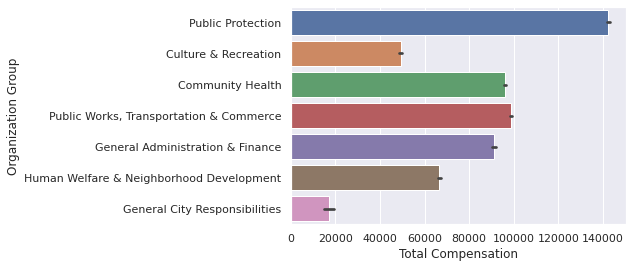

In [156]:
import seaborn as sns

org_groups = [data[0] for data in emp_df1.select("Organization Group").collect()]
Total_Compensation = [data[0] for data in emp_df1.select("Total Compensation").collect()]
sns.set_theme(style="darkgrid")

ax = sns.barplot(y=org_groups, x=Total_Compensation)
ax.set(ylabel='Organization Group', xlabel='Total Compensation')

#### 5.2. Find top Compensating Jobs. Display using bar plot

In [157]:
from pyspark.sql import DataFrame, SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [162]:
df1 = emp_df1.groupBy("Job") \
    .agg(max("Total Compensation").alias("total_comp")) \
    .orderBy(col("total_comp").desc())
df1.show(20, False)

+----------------------------------------+----------+
|Job                                     |total_comp|
+----------------------------------------+----------+
|Chief Investment Officer                |653498.1  |
|Deputy Chief 3                          |510574.44 |
|Asst Med Examiner                       |497505.0  |
|Chief Of Police                         |466798.22 |
|Dept Head V                             |433302.72 |
|Chief, Fire Department                  |426006.84 |
|Battlion Chief, Fire Suppressi          |425605.0  |
|Adm, SFGH Medical Center                |422799.94 |
|Executive Contract Employee             |422019.78 |
|Senior Physician Specialist             |418013.6  |
|Gen Mgr, Public Trnsp Dept              |410459.56 |
|Asst Chf Of Dept (Fire Dept)            |406063.03 |
|Dep Dir For Investments, Ret            |403743.75 |
|Deputy Sheriff                          |402204.5  |
|Administrator, Department Of Public Heal|395626.44 |
|Supervising Physician Spec 

In [163]:
top_jobs = [data[0] for data in df1.select("Job").collect()]
top_jobs = top_jobs[:5]
top_salaries = [data[0] for data in df1.select("total_comp").collect()]
top_salaries=top_salaries[:5]

[Text(0, 0.5, 'Job'), Text(0.5, 0, 'Total Compensation')]

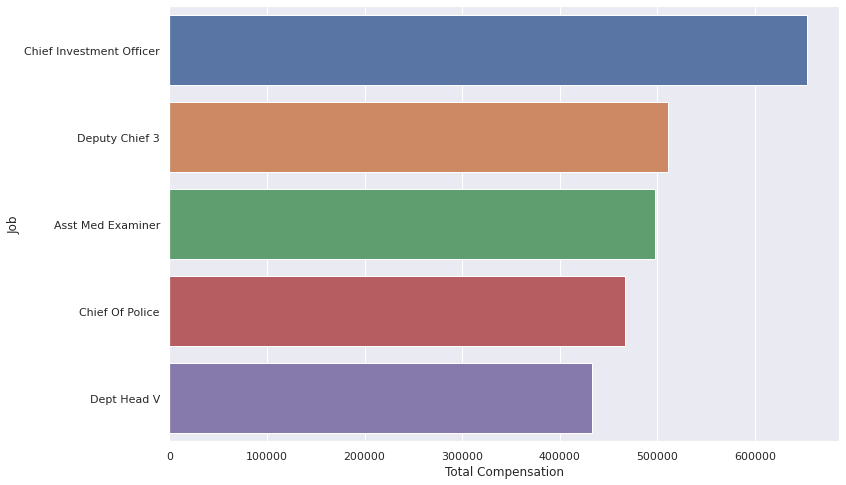

In [164]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.set_theme(style="darkgrid")
ax = sns.barplot(y=top_jobs, x=top_salaries)
ax.set(ylabel='Job', xlabel='Total Compensation')

#### 5.3. Check Correlation of Target Variable with Other Independent Variables. Plot Heatmap

In [165]:
numericalColumns = [item[0] for item in emp_df1.dtypes if not item[1].startswith('string')]
#print(numericalColumns)

from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import *

assembler = VectorAssembler(inputCols=numericalColumns, outputCol="features",handleInvalid='keep')
assembled_df = assembler.transform(emp_df1).select("features")

# correlation will be in Dense Matrix
correlation = Correlation.corr(assembled_df,"features","pearson").collect()[0][0]

# To convert Dense Matrix into DataFrame
rows = correlation.toArray().tolist()
print(type(rows))
#print(rows)
print(len(rows))

<class 'list'>
11


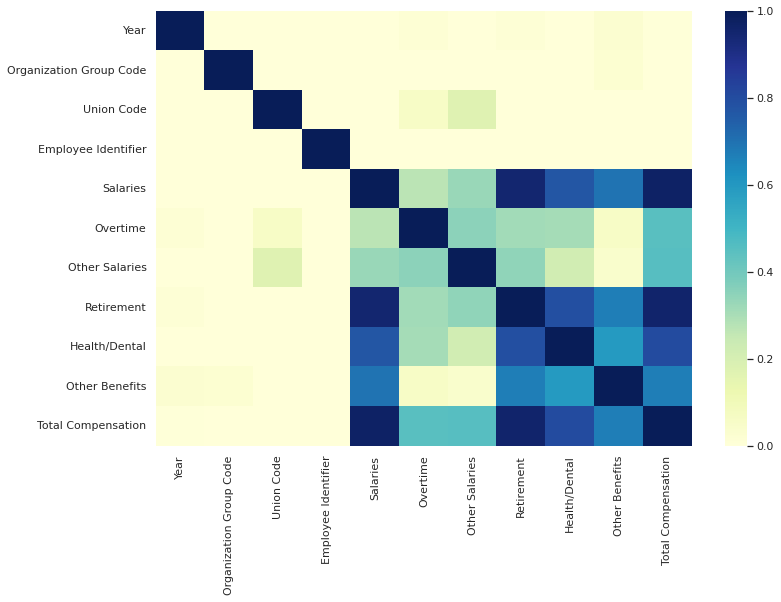

In [166]:
ax = sns.heatmap(rows, vmin=0, vmax=1, xticklabels = numericalColumns, yticklabels = numericalColumns,cmap="YlGnBu")

### 6. Perform necessary data pre-processing and divide the data into train and test set

Now that EDA is completed, we can drop descriptive columns like 'Organization', 'Department', 'Union', 'Job Family' and 'Job'

In [171]:
# dropping the descriptive redundant colums after EDA
red_desc_cols = ("Organization Group","Department","Union","Job Family","Job")
emp_df = emp_df.drop(*red_desc_cols)
print(len(emp_df.columns))
emp_df.printSchema()

15
root
 |-- Year Type: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Organization Group Code: integer (nullable = true)
 |-- Department Code: string (nullable = true)
 |-- Union Code: string (nullable = true)
 |-- Job Family Code: string (nullable = true)
 |-- Job Code: string (nullable = true)
 |-- Employee Identifier: integer (nullable = true)
 |-- Salaries: float (nullable = true)
 |-- Overtime: float (nullable = true)
 |-- Other Salaries: float (nullable = true)
 |-- Retirement: float (nullable = true)
 |-- Health/Dental: float (nullable = true)
 |-- Other Benefits: float (nullable = true)
 |-- Total Compensation: float (nullable = true)



### 6.1 Categorise the attributes into its type (Use one hot encoding wherever required)

In [172]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

categorical_col = [item[0] for item in emp_df1.dtypes if item[1].startswith('string')]
op_col = [i+"_indexed" for i in categorical_col]

indexer = StringIndexer(inputCols = categorical_col, outputCols = op_col, handleInvalid='keep')
model = indexer.fit(emp_df1)
indexed_df = model.transform(emp_df1)

out_col = [i+"Vec" for i in categorical_col]
encoder = OneHotEncoder(inputCols= op_col, outputCols=out_col)
encodedDF = encoder.fit(indexed_df).transform(indexed_df)
encodedDF.select('Year Type_indexed','Year TypeVec','Department Code_indexed','Department CodeVec',
                 'Job Family Code_indexed', 'Job Family CodeVec', 'Job Code_indexed', 'Job CodeVec').show(5, False)


+-----------------+-------------+-----------------------+------------------+-----------------------+------------------+----------------+------------------+
|Year Type_indexed|Year TypeVec |Department Code_indexed|Department CodeVec|Job Family Code_indexed|Job Family CodeVec|Job Code_indexed|Job CodeVec       |
+-----------------+-------------+-----------------------+------------------+-----------------------+------------------+----------------+------------------+
|0.0              |(2,[0],[1.0])|19.0                   |(54,[19],[1.0])   |16.0                   |(56,[16],[1.0])   |14.0            |(1129,[14],[1.0]) |
|1.0              |(2,[1],[1.0])|43.0                   |(54,[43],[1.0])   |14.0                   |(56,[14],[1.0])   |135.0           |(1129,[135],[1.0])|
|1.0              |(2,[1],[1.0])|0.0                    |(54,[0],[1.0])    |5.0                    |(56,[5],[1.0])    |20.0            |(1129,[20],[1.0]) |
|0.0              |(2,[0],[1.0])|0.0                    |(54,[0]

In [173]:
print(encodedDF.columns)

['Year Type', 'Year', 'Organization Group Code', 'Organization Group', 'Department Code', 'Department', 'Union Code', 'Union', 'Job Family Code', 'Job Family', 'Job Code', 'Job', 'Employee Identifier', 'Salaries', 'Overtime', 'Other Salaries', 'Retirement', 'Health/Dental', 'Other Benefits', 'Total Compensation', 'Year Type_indexed', 'Organization Group_indexed', 'Department Code_indexed', 'Department_indexed', 'Union_indexed', 'Job Family Code_indexed', 'Job Family_indexed', 'Job Code_indexed', 'Job_indexed', 'Year TypeVec', 'Organization GroupVec', 'Department CodeVec', 'DepartmentVec', 'UnionVec', 'Job Family CodeVec', 'Job FamilyVec', 'Job CodeVec', 'JobVec']


In [174]:
encodedDF.printSchema()

root
 |-- Year Type: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Organization Group Code: integer (nullable = true)
 |-- Organization Group: string (nullable = true)
 |-- Department Code: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- Union Code: integer (nullable = true)
 |-- Union: string (nullable = true)
 |-- Job Family Code: string (nullable = true)
 |-- Job Family: string (nullable = true)
 |-- Job Code: string (nullable = true)
 |-- Job: string (nullable = true)
 |-- Employee Identifier: integer (nullable = true)
 |-- Salaries: float (nullable = true)
 |-- Overtime: float (nullable = true)
 |-- Other Salaries: float (nullable = true)
 |-- Retirement: float (nullable = true)
 |-- Health/Dental: float (nullable = true)
 |-- Other Benefits: float (nullable = true)
 |-- Total Compensation: float (nullable = true)
 |-- Year Type_indexed: double (nullable = false)
 |-- Organization Group_indexed: double (nullable = false)
 |-- Department

In [175]:
from pyspark.ml.feature import VectorAssembler

featurecol = ['Year', 'Organization Group Code', 'Union Code', 'Employee Identifier', 'Salaries', 'Overtime', 'Other Salaries',
'Retirement', 'Health/Dental', 'Other Benefits', 'Year TypeVec', 'Department CodeVec',
 'Job Family CodeVec', 'Job CodeVec']

# Create the VectorAssembler object
assembler = VectorAssembler(inputCols= featurecol, outputCol= "features")
assembledDF = assembler.transform(encodedDF)

In [176]:
from pyspark.sql import functions as F
from pyspark.ml.linalg import Vectors, VectorUDT

# Define a udf that converts sparse vector into dense vector
# You cannot create your own custom function and run that against the data directly. 
# In Spark, You have to register the function first using udf function
sparseToDense = F.udf(lambda v : Vectors.dense(v), VectorUDT())

# We then call the function here passing the column name on which the function has to be applied
densefeatureDF = assembledDF.withColumn('features_array', sparseToDense('features'))

densefeatureDF.select("features", "features_array").show(5, False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [177]:
# Import StandardScaler from pyspark.ml.feature package
from pyspark.ml.feature import StandardScaler

# Create the StandardScaler object. It only take feature column (dense vector)
stdscaler = StandardScaler(inputCol= "features_array", outputCol= "scaledfeatures")

# Fit the StandardScaler object on the output of the dense vector data and transform
stdscaledDF = stdscaler.fit(densefeatureDF).transform(densefeatureDF)
stdscaledDF.select("scaledfeatures" ).show(5, False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 6.2 Split the data into train and test set

In [178]:
# We spilt the data into 70-30 set
# Training Set - 70% obesevations
# Testing Set - 30% observations
trainDF, testDF =  assembledDF.randomSplit([0.7,0.3], seed = 2020)

# print the count of observations in each set
print("Observations in training set = ", trainDF.count())
print("Observations in testing set = ", testDF.count())

Observations in training set =  203282
Observations in testing set =  87064


### 7. Fit Linear Regression model on the data and check its performance

In [179]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='Total Compensation', maxIter=10, 
                      regParam=0.8, elasticNetParam=0.1)
lr_model = lr.fit(trainDF)

trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

lr_predictions = lr_model.transform(testDF)
lr_predictions.select("prediction","Total Compensation","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Total Compensation",metricName="r2")
print("R Squared (R2) on val data = %g" % lr_evaluator.evaluate(lr_predictions))

RMSE: 4599.756797
r2: 0.995380
+------------------+------------------+--------------------+
|        prediction|Total Compensation|            features|
+------------------+------------------+--------------------+
| 145441.1949637215|         145278.19|(1251,[0,1,2,3,4,...|
| 183993.3566890462|         198466.97|(1251,[0,1,2,3,4,...|
|181228.56326261215|         204307.53|(1251,[0,1,2,3,4,...|
| 166449.6633635441|         167077.81|(1251,[0,1,2,3,4,...|
| 166871.4663451742|         167252.22|(1251,[0,1,2,3,4,...|
+------------------+------------------+--------------------+
only showing top 5 rows

R Squared (R2) on val data = 0.995303


### 8. Fit Decision Tree Regression model on the data and check its performance (Optional)

#### NOTE :  Fitting the Decision train was taking a very long time and hanging the machine, so skipping 

In [ ]:
# We spilt the data into 70-30 set
# Training Set - 70% obesevations
# Testing Set - 30% observations
#trainDF1, testDF1 =  stdscaledDF.randomSplit([0.7,0.3], seed = 2020)

# print the count of observations in each set
#print("Observations in training set = ", trainDF1.count())
#print("Observations in testing set = ", testDF1.count())

#from pyspark.ml.regression import DecisionTreeRegressor
#dt = DecisionTreeRegressor(featuresCol ='scaled_features', labelCol = 'Total Compensation')
#dt_model = dt.fit(trainDF)



### Model Persistence (Optional)
Model persistence means saving your model to a disk. After you finalize your model for prediction depending upon the performance, you need to save the model to the disk. Let's say, you finalize 'lrmodel' to be used for in production environment i.e. in your application. We use the following code to save it.

##### Saving the model

In [180]:
# use save() method to save the model
# write().overwrite() is usually used when you want to replace the older model with a new one
# It might happen that you wish to retrain your model and save it at the same the place
lr_model.write().overwrite().save("drive/MyDrive/Colab Notebooks/EmpComp_lr_Model.sav")

##### Loading the model

In [181]:
from pyspark.ml.regression import LinearRegressionModel

# load the model from the location it is stored
lr_model = LinearRegressionModel.load("drive/MyDrive/Colab Notebooks/EmpComp_lr_Model.sav")

lr_predictions = lr_model.transform(testDF)
lr_predictions.select("prediction","Total Compensation","features").show(5)


+------------------+------------------+--------------------+
|        prediction|Total Compensation|            features|
+------------------+------------------+--------------------+
| 145441.1949637215|         145278.19|(1251,[0,1,2,3,4,...|
| 183993.3566890462|         198466.97|(1251,[0,1,2,3,4,...|
|181228.56326261215|         204307.53|(1251,[0,1,2,3,4,...|
| 166449.6633635441|         167077.81|(1251,[0,1,2,3,4,...|
| 166871.4663451742|         167252.22|(1251,[0,1,2,3,4,...|
+------------------+------------------+--------------------+
only showing top 5 rows

